In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
%matplotlib inline

In [3]:
import optax
import numpy as onp
import jax.numpy as jnp
import jax.random
import jax_md
from jax import jit, vmap, grad, lax
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
import data
data_raw = data.get_gpaw_trajectories("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [6]:
from collections import defaultdict
SPECISES_MAP = defaultdict(lambda: 2)
SPECISES_MAP[16] = 0
SPECISES_MAP[42] = 1

opt = optax.chain(optax.clip_by_global_norm(jnp.float32(1.0)), optax.adam(jnp.float32(3e-4)))

In [7]:
def prepare_tensors(atoms):
  lattice = atoms.cell.array.astype(onp.float32)
  displacement, shift = jax_md.space.periodic_general(lattice.T, fractional_coordinates=False)
  species = jnp.array([SPECISES_MAP[this_type] for this_type in atoms.get_atomic_numbers()], dtype=jnp.int32)
  neighbor_fn, init_fn_bp, energy_fn_bp = jax_md.energy.behler_parrinello_neighbor_list(
    displacement=displacement,
    species=species,
    box_size=onp.float32(21),
    sym_kwargs={"cutoff_distance": onp.float32(4.7)})
  neighbor = neighbor_fn(atoms.positions, extra_capacity=3)
  
  @jit
  def train_energy_fn(params, R):
    _neighbor = neighbor_fn(R, neighbor)
    return energy_fn_bp(params, R, _neighbor)

  # Vectorize over states, not parameters.
  vectorized_energy_fn = vmap(train_energy_fn, (None, 0))

  grad_fn = grad(train_energy_fn, argnums=1)
  force_fn = lambda params, R, **kwargs: -grad_fn(params, R)
  vectorized_force_fn = vmap(force_fn, (None, 0))
  
  @jit
  def energy_loss(params, R, energy_targets):
    return jnp.mean((vectorized_energy_fn(params, R) - energy_targets) ** 2)

  @jit
  def force_loss(params, R, force_targets):
    dforces = vectorized_force_fn(params, R) - force_targets
    return jnp.mean(jnp.sum(dforces ** 2, axis=(1, 2)))
  
  @jit
  def loss(params, R, targets):
    return energy_loss(params, R, targets[0]) + force_loss(params, R, targets[1])
  
  @jit
  def update_step(params, opt_state, R, labels):
    updates, opt_state = opt.update(grad(loss)(params, R, labels),
                                    opt_state)
    return optax.apply_updates(params, updates), opt_state
  
  return init_fn_bp, neighbor_fn, vectorized_energy_fn, energy_loss, update_step

In [8]:
data_processed = {}
for key, defect_vars in data_raw.items():
  data_processed[key] = []
  for traj in defect_vars:
    energies = jnp.array([a.get_potential_energy() for a in traj], dtype=jnp.float32)
    coordinates = jnp.array([a.positions for a in traj], dtype=jnp.float32)
    forces = jnp.array([a.get_forces() for a in traj], dtype=jnp.float32)
  data_processed[key].append((energies, coordinates, forces))

In [9]:
tensors_per_id = {k: prepare_tensors(v[0][0]) for k, v in data_raw.items()}

In [36]:
key = jax.random.PRNGKey(42)
BASE='id24'
initial_coords = jnp.array(data_raw[BASE][0][0].positions)
base_funcs  = tensors_per_id[BASE]
neighbor = base_funcs[1](initial_coords, extra_capacity=3)
params = base_funcs[0](key, initial_coords, neighbor)

In [37]:
opt_state = opt.init(params)
train_energy_error = []

In [38]:
from IPython import display

In [39]:
for epoch in range(2):
  for defect_id in ['id24', 'id25']:
    for traj in data_processed[defect_id]:
      # Total eV
      train_energy_error += [onp.sqrt(tensors_per_id[defect_id][3](params, traj[1], traj[0]))]
      params, opt_state = tensors_per_id[defect_id][4](params, opt_state, traj[1], (traj[0], traj[2]))
  display.clear_output(wait=True)
  display.display(plt.gcf())
  fig, ax = plt.subplots()
  ax.plot(train_energy_error)
  plt.show();

AssertionError: 'BPEncoder/~/linear_0/w' with shape (156, 30) does not match shape=[82, 30] dtype=dtype('float32')

In [27]:
predicted = tensors_per_id[defect_id][2](params, traj[1])

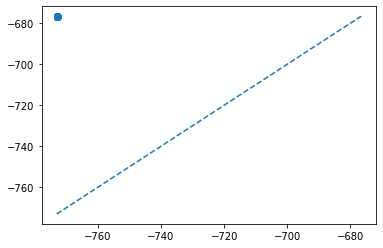

In [28]:
example_energies = traj[0]
min_energy = min(example_energies.min(), predicted.min())
max_energy = max(example_energies.max(), predicted.max())
plot_range = onp.linspace(min_energy, max_energy, 10)
plt.plot(plot_range, plot_range, '--')
plt.scatter(traj[0], predicted)